# About
Compare performance including and excluding hate against hegemonic groups using a logistic regression classifier.

Could merge with bert_hate_speech_classifier but probably not

# Train and evaluate LR hate speech classifiers
Load data, extract features, train classifiers, evaluate

In [16]:
# Load data
import pickle
import pdb
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report
import pandas as pd
from IPython.display import display
from tqdm.notebook import tqdm

datasets = [
    'kennedy2020',
    'elsherief2021',
    'salminen2018',
    'sbic',
    'cad',
]

scores = {}
f1_scores = [] # List of dicts with keys: dataset, split, f1 (to create df)

# for dataset in datasets[4:5]:
for dataset in tqdm(datasets):
    print(dataset)
    
    path = f'/storage2/mamille3/hegemonic_hate/tmp/{dataset}_hegsplits_0.3hate.pkl'
    with open(path, 'rb') as f:
        data = pickle.load(f)

    # Extract features
    print('Extracting features...')
    vectorizer = {}
    bow = {}
    for split in ['with_heg', 'no_heg']:
        # Check for NaNs
        if data[split]['train']['text'].isnull().values.any():
            pdb.set_trace()
        if data[split]['test']['text'].isnull().values.any():
            pdb.set_trace()
        vectorizer[split] = TfidfVectorizer(min_df=1)
        vectorizer[split].fit(data[split]['train']['text']) # corpus is a list of strings (documents)
        bow[split] = {}
        bow[split]['train'] = vectorizer[split].transform(data[split]['train']['text'])
        bow[split]['test'] = vectorizer[split].transform(data[split]['test']['text'])
    bow.keys()

    # Train LR model 
    print('Training model...')
    clf = {}
    for split in ['with_heg', 'no_heg']:
        clf[split] = LogisticRegression(solver='liblinear')
        clf[split].fit(bow[split]['train'], data[split]['train']['hate'])

    # Evaluate
    print('Evaluating...')
    scores[dataset] = {}
    for split in ['with_heg', 'no_heg']:
        preds = clf[split].predict(bow[split]['test'])
        true = data[split]['test']['hate']
        scores[dataset][split] = pd.DataFrame(classification_report(true, preds, output_dict=True))
        f1_scores.append({'dataset': dataset, 'split': split, 'f1_hate': scores[dataset][split].loc['f1-score', 'True']})
        # print(split)
        # display(scores[dataset][split])
    print()

f1_scores = pd.DataFrame(f1_scores)
f1_scores

  0%|          | 0/5 [00:00<?, ?it/s]

kennedy2020
Extracting features...
Training model...
Evaluating...

elsherief2021
Extracting features...
Training model...
Evaluating...

salminen2018
Extracting features...
Training model...
Evaluating...

sbic
Extracting features...
Training model...
Evaluating...

cad
Extracting features...
Training model...
Evaluating...



,dataset,split,f1_hate
0,kennedy2020,with_heg,0.832494
1,kennedy2020,no_heg,0.847058
2,elsherief2021,with_heg,0.424190
3,elsherief2021,no_heg,0.463320
4,salminen2018,with_heg,0.774468
5,salminen2018,no_heg,0.786540
6,sbic,with_heg,0.647589
7,sbic,no_heg,0.647887
8,cad,with_heg,0.496020
9,cad,no_heg,0.498150


# Visualize scores

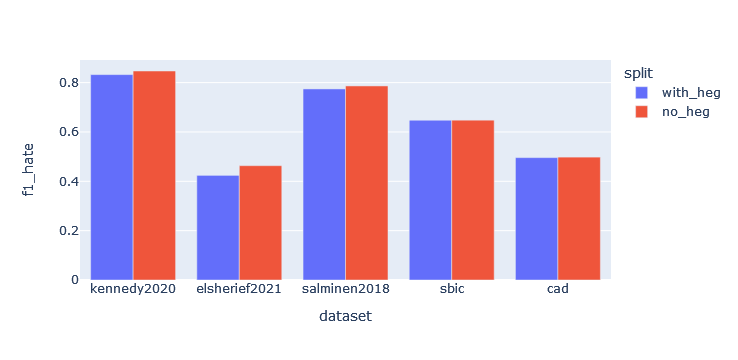

In [17]:
import plotly.express as px

px.bar(f1_scores, x='dataset', y='f1_hate', color='split', barmode='group')